# Clustering of images using Expectation Maximization
using gaussian maixture model via maximum likelyhood to form clusters

In [1]:
#importing relavant libraries
from scipy.stats import multivariate_normal
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import decomposition
from sklearn import datasets
%matplotlib inline

# About Dataset
we will be using Iris dataset. it is made of the following details:
    
Number of Instances: 150 (50 in each of three classes)
    
Number of Attributes: 4 numeric, predictive attributes and the class

Attribute Information:
    sepal length in cm
    sepal width in cm
    petal length in cm
    petal width in cm
    class: — Iris Setosa — Iris Versicolour — Iris Virginica

Missing Attribute Values: None

In [2]:
#data_path = "./iris.data"
iris = datasets.load_iris()
column_names = ["sepal_length","sepal_width","petal_length","petal_width","label"]
iris_data = iris.data
iris_target = np.reshape(iris.target,(-1,1))

concat_iris_data = np.concatenate((iris_data, iris_target), axis=1)
df = pd.DataFrame(concat_iris_data, columns = column_names)

In [3]:
#show random 5 samples
df.sample(5)

,sepal_length,sepal_width,petal_length,petal_width,label
15,5.7,4.4,1.5,0.4,0.0
50,7.0,3.2,4.7,1.4,1.0
7,5.0,3.4,1.5,0.2,0.0
81,5.5,2.4,3.7,1.0,1.0
74,6.4,2.9,4.3,1.3,1.0


In [4]:
X = df.iloc[:,:4].values
y = df.iloc[:,4].values

#Project data to lower dimension using PCA,i.e, 4 dimension to 2 dimension
pca = decomposition.PCA(n_components=2)
pca.fit(X)
X = pca.transform(X)

#create a dataframe combining the low dimension data and to be used for visualization
low_dim_data = {
        'X1': X[:,0],
        'X2': X[:,1],
        'label': y}
low_dim_df = pd.DataFrame(low_dim_data, columns = ['X1', 'X2', 'label'])


In [5]:
low_dim_df.sample(5)

,X1,X2,label
53,0.183318,-0.827959,1.0
13,-3.223804,-0.511395,0.0
10,-2.506947,0.645069,0.0
40,-2.770102,0.263528,0.0
85,0.806858,0.194182,1.0


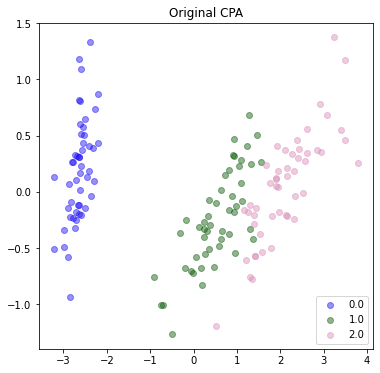

In [6]:
fig, (axs) = plt.subplots(1,1, figsize = (6,6))

# Plot each group in each dataset as unique olor
for ax, low_dim_df in zip([axs], [low_dim_df]):
    ax.set_title('Original CPA')
    for cat, col in zip(low_dim_df['label'].unique(), ['#190BF5', '#0B5A07', '#DA8DB9']):
        ax.scatter(low_dim_df[low_dim_df.label == cat].X1, low_dim_df[low_dim_df.label == cat].X2, c = col, label = cat, alpha = .45)
    ax.legend()

In [7]:
# Implement K-means ++ to initialize centers
def pick_cluster_centers(points, num_clusters = 3):
    # Create List to store clusters
    clusters = []
    # Save list of cluster indicies
    arr_idx = np.arange(len(points))
    # Choose first cluster; append to list
    clusters.append( (points[np.random.choice(arr_idx)],1.0 / num_clusters,np.identity(points.shape[1], dtype=np.float64)))
    # Define function to calculate squared distance
    def dist_sq(x): return np.linalg.norm(x)**2
    c_dist = None
    # Add Clusters until reaching "num_clusters"
    while len(clusters) < num_clusters:
        # Calculate distance between latest cluster and rest of points
        new_dist = np.apply_along_axis(dist_sq, 1, points - clusters[-1][0]).reshape(-1,1)
        
        # Add to distance array - First check to see if distance matrix exists
        if type(c_dist) == type(None):
            c_dist = new_dist
        else:
            c_dist = np.concatenate([c_dist, new_dist], axis = 1)
            
        # Calculate probability by finding shortest distance, then normalizing
        c_prob = np.apply_along_axis(np.min, 1, c_dist)
        c_prob = c_prob / c_prob.sum()
        # Draw new cluster according to probability
        clusters.append((points[np.random.choice(arr_idx, p = c_prob)],1.0 / num_clusters,np.identity(points.shape[1], dtype=np.float64)))
    return np.array(clusters)

In [8]:
def assign_clusters_GMM(points, clusters):
    # calculate the pdf given a mu and sigma, then multiply by pi
    def pdf_calc_func(mu, pi, Sigma):
        return lambda x: pi*stats.multivariate_normal(mu, Sigma).pdf(x)
    # Create list for saving weights
    clust_weights = []
    # For each cluster
    for c in clusters:
        # Create the custom pdf function
        pdf = pdf_calc_func(*c)
        # Apply to all the points
        clust_weights.append(np.apply_along_axis(pdf, 1, points).reshape(-1,1))
    # Combine all points
    clust_weights = np.concatenate(clust_weights, axis = 1)
    # Define normalizatino function and normalize
    def norm_clust_weights(x):
        return [n/np.sum(x) for n in x]
    cluster_assignments = np.apply_along_axis(norm_clust_weights, 1, clust_weights)
    
    return cluster_assignments,clust_weights

In [9]:
 def update_clusters_GMM(points, cluster_weights):
    # Create list for clusters
    new_clusts = []
    # For each cluster
    for c in cluster_weights.T:
        n_k = np.sum(c) # Calculate n
        pi_k = n_k / len(points) # calculate pi
        # Calculate mu
        mu_k = np.apply_along_axis(np.sum,0,points * c.reshape(-1,1)) / n_k
        # Initialize Sigma
        Sigma_k = 0
        # For every weight and point
        for cw, p in zip(c, points):
            diff = p - mu_k # Find Difference
            # Dot Product times weight
            Sigma_k += cw * np.matmul(diff.reshape(-1,1), diff.reshape(1,-1))
        # Normalize Sigma
        Sigma_k = Sigma_k / n_k
        # Create cluster tuple, and add to list
        new_c = (mu_k, pi_k, Sigma_k)
        new_clusts.append(new_c)
    return new_clusts

In [10]:
def get_log_likelihood(likelihood):
    
    log_likelihoods = np.sum(likelihood)
    return np.log(log_likelihoods)


In [11]:
# Create function that will create clustering functions
def create_cluster_func(assign_func, update_func, threshold_func, assign_args = {}):
    
    def cluster(points, centroids, max_iter = 100, stop_threshold = .0001):
        cluster_means_diffs = []
        log_likelihoods = []
        history = []
        cluster_assign_history = []
        for i in range(max_iter):
            old_centroids = centroids
            
            cluster_weights,likelihood = assign_func(points, centroids, **assign_args)
            
            log_likelihood = get_log_likelihood(likelihood)
            log_likelihoods.append(log_likelihood)
            centroids = update_func(points, cluster_weights)
            
            clusters_snapshot = []
        
            # This is just for our later use in the graphs
            for cluster in centroids:
                
                clusters_snapshot.append({
                    'mu_k': cluster[0],
                    'cov_k': cluster[2]
                })

            history.append(clusters_snapshot)
            cluster_assign_history.append(cluster_weights)
            
            status,metric = threshold_func(centroids, old_centroids, stop_threshold)
            cluster_means_diffs.append(metric)
            print('Iteration',i + 1,'Likelihood: ', log_likelihood)
            
            if status:
                break
        
        return (centroids,cluster_weights,cluster_means_diffs,log_likelihoods,history,cluster_assign_history)
    return cluster

# Create functions that test for convergence
def basic_threshold_test(centroids, old_centroids, stop_threshold):
    
    for n, o in zip(centroids, old_centroids):
        #print(n,o)
        metric = np.linalg.norm(n-o)
        if metric > stop_threshold:
            return (False,metric)
    return (True,metric)

# Create functions that test for convergence
def GMM_threshold_test(centroids, old_centroids, stop_threshold):
    for np, op in zip(centroids, old_centroids):
        status,metric = basic_threshold_test(np,op,stop_threshold)
        if not status:
            return (status,metric)
    return (status,metric)

In [12]:
### Creating actual functions for clustering
cluster_GMM = create_cluster_func(assign_clusters_GMM,
                                      update_clusters_GMM,
                                      GMM_threshold_test)

In [13]:
def train(df,clusters = 3,max_iter = 100):
    # Pull out point data
        points = df.iloc[:,:4].values
        
        # Pick random initial centers
        init_cents = pick_cluster_centers(points, clusters)
        
        
        # Calculate centers from custom function
        cents,cluster_assignments,cluster_means_diffs,log_likelihoods,history,cluster_assign_history = cluster_GMM(points ,init_cents,max_iter)
        
        return (cents,cluster_assignments,cluster_means_diffs,log_likelihoods,history,cluster_assign_history)

In [14]:
%%time
cents,cluster_assignments,cluster_means_diffs,log_likelihoods,history,cluster_assign_history = train(df,3, 50)

Iteration 1 Likelihood:  -0.166567368991004
Iteration 2 Likelihood:  4.300901004827291
Iteration 3 Likelihood:  4.726981374480702
Iteration 4 Likelihood:  4.736918787740194
Iteration 5 Likelihood:  4.7410871955713025
Iteration 6 Likelihood:  4.742506099543832
Iteration 7 Likelihood:  4.743599542294891
Iteration 8 Likelihood:  4.7449356308507165
Iteration 9 Likelihood:  4.746813972275816
Iteration 10 Likelihood:  4.749520086736632
Iteration 11 Likelihood:  4.753172348490618
Iteration 12 Likelihood:  4.757709184796634
Iteration 13 Likelihood:  4.763051868736822
Iteration 14 Likelihood:  4.769140363230425
Iteration 15 Likelihood:  4.775693612001519
Iteration 16 Likelihood:  4.7821669511421705
Iteration 17 Likelihood:  4.788426656982925
Iteration 18 Likelihood:  4.794465753051645
Iteration 19 Likelihood:  4.800186520129526
Iteration 20 Likelihood:  4.806023367272962
Iteration 21 Likelihood:  4.8128797495254565
Iteration 22 Likelihood:  4.819169795469392
Iteration 23 Likelihood:  4.82249106

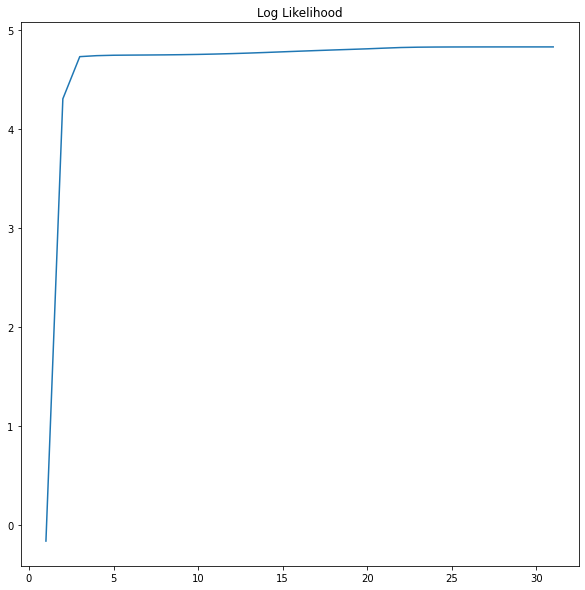

In [15]:
plt.figure(figsize=(10, 10))
plt.title('Log Likelihood')
plt.plot(np.arange(1, len(log_likelihoods)+1), log_likelihoods)
plt.show()

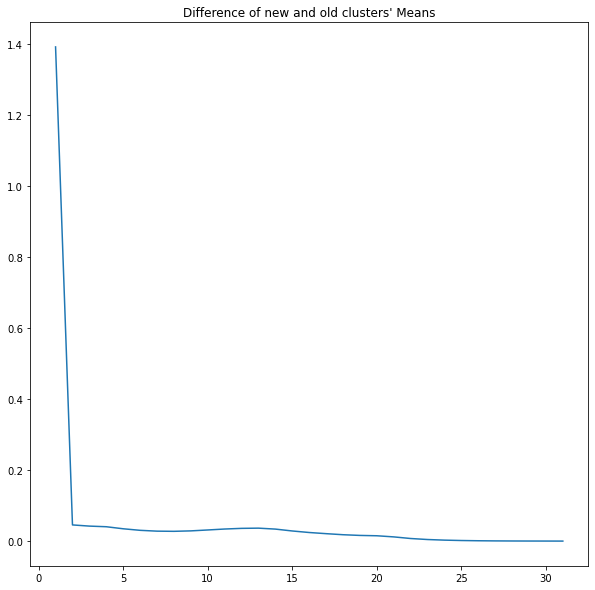

In [16]:
plt.figure(figsize=(10, 10))
plt.title('Difference of new and old clusters\' Means')
plt.plot(np.arange(1, len(cluster_means_diffs)+1), cluster_means_diffs)
plt.show()

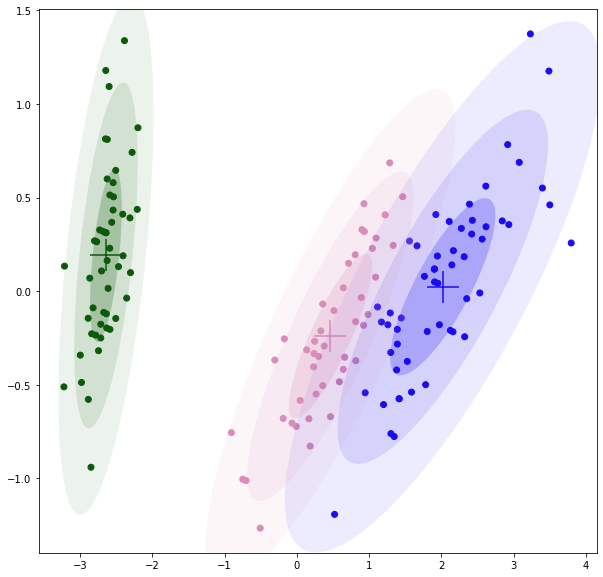

In [17]:
import matplotlib.colors as colors
from matplotlib.colors import to_hex, to_rgb
from matplotlib.patches import Ellipse
from PIL import Image
import imageio
import matplotlib.animation as ani
def create_cluster_animation(df, history, scores):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    colorset = ['#190BF5', '#0B5A07', '#DA8DB9']
    images = []
    
    #assign colors according to probabilities
    def find_hex(p, colors):
        p = p.reshape(-1,1)
        return to_hex(np.sum(p*colors, axis=0))
    
    for j, clusters in enumerate(history):
      
        idx = 0
      
        if j % 3 != 0:
            continue
        
        plt.cla()
        
        low_dim_cents_custom = update_clusters_GMM(low_dim_df.iloc[:,:2].values, scores[j])
        for cluster in low_dim_cents_custom:
            mu = cluster[0]
            cov = cluster[2]
            
            eigenvalues, eigenvectors = np.linalg.eigh(cov)
            order = eigenvalues.argsort()[::-1]
            eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
            vx, vy = eigenvectors[:,0][0], eigenvectors[:,0][1]
            theta = np.arctan2(vy, vx)

            color = colors.to_rgba(colorset[idx])

            for cov_factor in range(1, 4):
                ell = Ellipse(xy=mu, width=np.sqrt(eigenvalues[0]) * cov_factor * 2, height=np.sqrt(eigenvalues[1]) * cov_factor * 2, angle=np.degrees(theta), linewidth=2)
                ell.set_facecolor((color[0], color[1], color[2], 1.0 / (cov_factor * 4.5)))
                ax.add_artist(ell)

            ax.scatter(mu[0], mu[1], c=colorset[idx], s=1000, marker='+')
            idx += 1

        #for i in range(df.shape[0]):
            
        custom_colors = [np.array(to_rgb(c)) for c in colorset]
        custom_colors = np.array(custom_colors)

        plot_colors = [find_hex(p,custom_colors) for p in scores[j]]
            
        ax.scatter(df.X1, df.X2, c=plot_colors, marker='o')
        
        fig.canvas.draw()
        
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        images.append(image)
    
    kwargs_write = {'fps':1.0, 'quantizer':'nq'}
    imageio.mimsave('./gmm.gif', images, fps=1)
    plt.show(Image.open('gmm.gif').convert('RGB'))
    
    
create_cluster_animation(low_dim_df, history, cluster_assign_history)